In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs
import tf_lab.point_clouds.in_out as pio
import tf_lab.models.point_net_based_AE as pnAE
from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id
from tf_lab.point_clouds.in_out import PointCloudDataSet
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf

from tf_lab.autopredictors.evaluate.basics import eval_model, read_saved_epochs
from tf_lab.autopredictors.plotting.basics import plot_original_pclouds_vs_reconstructed,\
                                                  plot_train_val_test_curves, plot_reconstructions_at_epoch


from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from geo_tool import Point_Cloud


/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

class_type = raw_input('Give me the class type.\n').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/1024/', class_syn_id)

train_dir = osp.join(top_data_dir, 'OUT/models/incomplete_pclouds/')

# experiment_name = 'virt_scan_' + class_syn_id + '_only_ae'
# train_dir = osp.join(train_dir, experiment_name)

experiment_name = 'denoising-chairs-pnet_complex_decoder'
train_dir = osp.join(train_dir, 'blensor_data', experiment_name)

create_dir(train_dir)

Give me the class type.
chair


'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/blensor_data/denoising-chairs-pnet_complex_decoder'

In [4]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds, full_model_names, class_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=11)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

6778 files containing complete point clouds were found.


In [5]:
blensor_data = osp.join(top_data_dir, 'Blensor_Incomplete_Pclouds/', class_syn_id)
noisy_pcloud_files = pio.load_filenames_of_input_data(blensor_data, pio.blensor_search_pattern)
noisy_pclouds, noisy_model_names, class_ids = pio.load_crude_point_clouds(file_names=noisy_pcloud_files, 
                                                                n_threads=11, 
                                                                loader=pio._load_blensor_incomplete_pcloud)


# virtual_scan_data = osp.join(top_data_dir, 'From_Mathhias/shapenet_dim32_sdf_pc', class_syn_id)
# noisy_pcloud_files = pio.load_filenames_of_input_data(virtual_scan_data, pio.vscan_search_pattern)
# noisy_pclouds, noisy_model_names, class_ids = pio.load_crude_point_clouds(file_names=noisy_pcloud_files, 
#                                                                 n_threads=11, 
#                                                                 loader=pio._load_virtual_scan_incomplete_pcloud)

print '%d files containing noisy point clouds were found.' % (len(noisy_pclouds), )

3738 files containing noisy point clouds were found.


In [6]:
# Match incomplete to complete data. (single class code)
d = {name:i for i, name in enumerate(full_model_names)}
mapping = [] # The i-th noisy pcloud will correspond to the mapping[i] in the original order.
for name in noisy_model_names:
    mapping.append(d[name])
mapping = np.array(mapping)
full_pclouds_matched = full_pclouds[mapping]

In [7]:
train_data_, _, test_data_ = pio.train_validate_test_split([full_pclouds_matched,
                                                            noisy_pclouds, 
                                                            noisy_model_names],
                                                            train_perc=0.9,
                                                            validate_perc=0.0,
                                                            test_perc=0.1,
                                                            seed=seed)

train_data = PointCloudDataSet(train_data_[0], noise=train_data_[1], labels=train_data_[2])
test_data = PointCloudDataSet(test_data_[0], noise=test_data_[1], labels=test_data_[2])

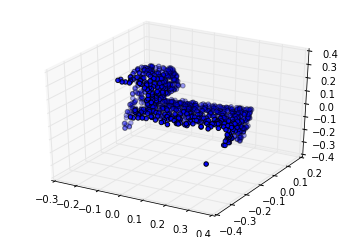

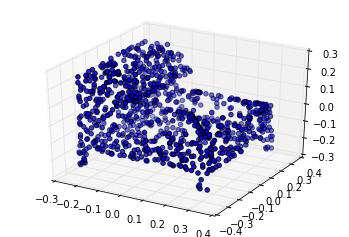

In [22]:
# # TRY ME.
pp = test_data.next_batch(1)
Point_Cloud(points=pp[2].reshape(1024, 3)).plot();
Point_Cloud(points=pp[0].reshape(1024, 3)).plot();

In [23]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

set_visible_GPUs([1])

conf = Conf(n_input = [1024, 3],
               training_epochs = 1000,
               batch_size = 40,
               loss = 'Chamfer',
               train_dir = train_dir,
               loss_display_step = 1,
               saver_step = 5,
               learning_rate = 0.0002,
               saver_max_to_keep = 200,
               gauss_augment = {'mu': 0, 'sigma': 0.02},
               encoder = pnAE.encoder,
               decoder = pnAE.decoder,
               spatial_trans = True,             
               denoising = True
              )

reset_graph()
ae = PointNetAutoEncoder(experiment_name, conf)

if conf.debug:
    ae.train_names = set(train_data_[2])

In [25]:
saved_epochs = read_saved_epochs(conf.train_dir)
epochs = saved_epochs[::len(saved_epochs)/10]
stats = eval_model(ae, conf, [train_data, test_data], epochs=epochs, verbose=True)

Model restored in epoch 5.
[ 0.00393329  0.00381215]
Model restored in epoch 105.
[ 0.00790631  0.00836251]
Model restored in epoch 205.
[ 0.00765842  0.00792974]
Model restored in epoch 305.
[ 0.00924322  0.01008168]
Model restored in epoch 405.
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 970, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 233, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 267, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/usr/lib/python2.7/inspect.py", line 1044, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/usr/lib/python2.7/inspect.py", line 1004, in getframeinfo
    filename = getsourcefile(f

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



TypeError: 'NoneType' object is not iterable

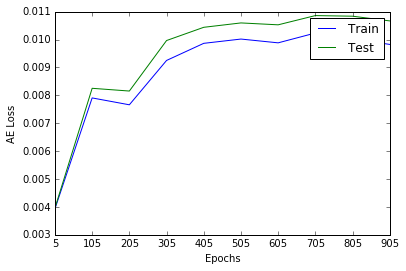

In [35]:
# top_save_dir = osp.join(top_data_dir, 'OUT/model_evaluation/incomplete_pclouds/virt_scan_03001627_only_ae/')

top_save_dir = osp.join(top_data_dir, 'OUT/model_evaluation/incomplete_pclouds/blensor_data/')
plot_train_val_test_curves(stats, top_save_dir, has_validation=False, best_epoch=None, show=True)

In [52]:
best_epoch = 185
save_dir = osp.join(top_save_dir, 'test_images_epoch_' + str(best_epoch))
plot_reconstructions_at_epoch(best_epoch, ae, test_data, conf, save_dir=save_dir, max_plot=200)

last_epoch = saved_epochs[-1]
save_dir = osp.join(top_save_dir, 'train_images_epoch_' + str(last_epoch))
plot_reconstructions_at_epoch(last_epoch, ae, train_data, conf, save_dir=save_dir, max_plot=200)